Prediction of the BTC volatility using LSTM.

In [77]:
from datetime import datetime

import jax
import yfinance as yf
from flax import nnx
import jax.numpy as jnp
import pandas as pd
import tqdm



Lets first download the data.

In [69]:
import os

def download_data(ticker: str, start: str, end: str) -> pd.DataFrame:
    """Download historical data for a given ticker."""
    # check if the data is already downloaded
    if f"{ticker}_data.csv" in os.listdir():
        print(f"Data for {ticker} already downloaded.")
        dataframe = pd.read_csv(f"{ticker}_data.csv", index_col=0, parse_dates=True, date_format="%Y-%m-%d")
        # remove first two rows as they are not needed
        dataframe = dataframe.iloc[2:]
        # interpret all but the first column as float
        for col in dataframe.columns[1:]:
            dataframe[col] = pd.to_numeric(dataframe[col], errors='raise')
        dataframe['Close'] = pd.to_numeric(dataframe['Close'], errors='raise')
        return dataframe


    data = yf.download(ticker, start=start, end=end)
    # save the data to a CSV file
    data.to_csv(f"{ticker}_data.csv")

    return data


btc = download_data('BTC-USD', start='2015-01-01', end='2023-10-01')
#btc = yf.download('BTC-USD', start='2015-01-01', end='2023-10-01')
btc.info()

Data for BTC-USD already downloaded.
<class 'pandas.core.frame.DataFrame'>
Index: 3195 entries, 2015-01-01 to 2023-09-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3195 non-null   float64
 1   High    3195 non-null   float64
 2   Low     3195 non-null   float64
 3   Open    3195 non-null   float64
 4   Volume  3195 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 149.8+ KB


In [70]:
def calculate_daily_volatility(data: pd.DataFrame, window: int = 30) -> pd.DataFrame:
    data['Returns'] = data['Close'].pct_change()
    data['Annualized_Volatility'] = data['Returns'].rolling(window=window).std() * (252 ** 0.5)  # Annualize the volatility
    return data

btc = calculate_daily_volatility(btc)
btc = btc.dropna()
btc.head()

,Close,High,Low,Open,Volume,Returns,Annualized_Volatility
Price,,,,,,,
2015-01-31,217.464005,233.503998,216.309006,226.440994,23348200,-0.039576,1.189920
2015-02-01,226.972000,231.574005,212.014999,216.867004,29128500,0.043722,1.199454
2015-02-02,238.229004,242.175003,222.658997,226.490997,30612100,0.049596,1.172109
2015-02-03,227.268005,245.957001,224.483002,237.453995,40783700,-0.046010,1.166827
2015-02-04,226.852997,230.057999,221.113007,227.511002,26594300,-0.001826,1.160287


In [71]:
# preprocessing the data
def scale_dataframe_minus_one_to_one(df: pd.DataFrame, columns_to_scale: list[str]) -> pd.DataFrame:
    """
    Scales all numeric columns in a Pandas DataFrame to the range [-1, 1].

    Args:
        df: The input Pandas DataFrame.

    Returns:
        A new Pandas DataFrame with numeric columns scaled to [-1, 1].
        Non-numeric columns are returned unchanged.
        :param columns_to_scale:
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_scaled = df.copy()

    # Iterate over each column in the DataFrame
    for column in df_scaled.columns:
        # Check if the column is numeric
        if pd.api.types.is_numeric_dtype(df_scaled[column]) and column in columns_to_scale:
            min_val = df_scaled[column].min()
            max_val = df_scaled[column].max()

            # Check if min_val and max_val are the same to avoid division by zero
            if min_val == max_val:
                # If all values are the same, scale them to 0
                # (or you could choose -1 or 1, but 0 is neutral)
                df_scaled[column] = 0.0
            else:
                # Apply the scaling formula: 2 * (x - min) / (max - min) - 1
                df_scaled[column] = 2 * (df_scaled[column] - min_val) / (max_val - min_val) - 1
        else:
            # If column is not numeric, print a warning and leave it as is
            print(f"Warning: Column '{column}' is not numeric and will not be scaled.")

    return df_scaled
def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    # To Test the targe will be the index in of the next row
    data['Target'] = data['Annualized_Volatility'].shift(-1)  # Shift the target by one row
    # Drop the last row as it will have NaN target
    data = data.dropna()
    # Select relevant features
    features = ['Annualized_Volatility']# ['Open', 'High', 'Low', 'Close', 'Volume'] # ggf add annualized volatility

    # scale the features between -1 and 1
    data = scale_dataframe_minus_one_to_one(data, features)




    return data[features + ['Target']]

preprocess_data(btc).head(100)

,Annualized_Volatility,Target
Price,,
2015-01-31,0.611267,1.199454
2015-02-01,0.625526,1.172109
2015-02-02,0.584628,1.166827
2015-02-03,0.576728,1.160287
2015-02-04,0.566945,1.157118
...,...,...
2015-05-06,-0.595789,0.396399
2015-05-07,-0.575574,0.394430
2015-05-08,-0.578518,0.394868


Now let's create a simple LSTM model to predict the volatility...

In [72]:

class LSTM(nnx.Module):
    features: int

    def __init__(self, features: int, hidden_features: int, *, rngs: jax.random.PRNGKey):
        self.rngs, initial_rngs = jax.random.split(rngs)
        self.rngs, initial_linear_rngs = jax.random.split(self.rngs)

        self.features = features
        self.hidden_size = hidden_features

        self.lstm_cell = nnx.LSTMCell(
            features,  # Number of features in the input
            hidden_features,  # Size of the hidden state
            rngs=nnx.Rngs(initial_rngs)  # Random number generator for initialization
        )
        self.lstm_layer = nnx.RNN(
            self.lstm_cell,  # The LSTM cell to use
            return_carry=False,
            rngs=nnx.Rngs(initial_rngs)  # Random number generator for initialization
        )
     #   self.linear_test = nnx.Linear(features, self.hidden_size, rngs=nnx.Rngs(initial_rngs))  # Linear layer to transform input features
        self.linear = nnx.Linear(hidden_features, 1, rngs=nnx.Rngs(initial_linear_rngs))
        # Linear layer to output the prediction


    def __call__(self, x):
        """Forward pass of the LSTM model."""
        y = self.lstm_layer(x)  # Pass the input through the LSTM layer
        last_layer_output = y[:, -1, :]
        # Get the last output of the LSTM
        #last_layer_output = self.linear_test(x)
        y = self.linear(last_layer_output)  # Pass through the
        return y

    def initial_state(self, batch_size: int):
        return jnp.zeros((batch_size, self.hidden_size))



#model = LSTM(features=1, hidden_features=256, rngs=jax.random.PRNGKey(0))  # 6 features: Open, High, Low, Close, Volume
#nnx.display(model)


In [73]:
import optax


# Alright, now lets define some helper functions
def compute_metrics(predictions: jnp.ndarray, targets: jnp.ndarray) -> dict:
    """Compute metrics for the model predictions."""
    mse = jnp.mean((predictions - targets) ** 2)
    mae = jnp.mean(jnp.abs(predictions - targets))
    return {'mse': mse, 'mae': mae}

def create_training_state(rng: nnx.Rngs) -> tuple[nnx.Module, optax.GradientTransformation]:
    """Create a training state for the model."""
    lstm = LSTM(features=6, rngs=rng)
    tx = optax.adam(1e-3)
    return lstm, tx

def loss_fn(model: LSTM, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    y_pred = model(x)
    return jnp.mean((y_pred - y) ** 2)

@nnx.jit  # Automatic state management
def train_step(model, optimizer, x, y):
  grad_fn = nnx.value_and_grad(loss_fn)  # Compute gradients and loss
  loss, grads = grad_fn(model, x, y)  # Compute the loss and gradient
  optimizer.update(grads)  # In place updates.
  return loss

def transform_data_to_training_timeseries(data: pd.DataFrame, window_size: int = 100) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Transform the DataFrame into a time series format for training."""
    # Convert DataFrame to JAX array
    y = jnp.array(data['Target'])
    x_unformatted = jnp.array(data.drop(columns=['Target']))
    # Create a rolling timeseries dataset
    x = jnp.array([x_unformatted[i:i + window_size] for i in range(len(x_unformatted) - window_size)])
    # drop the last window_size rows from y
    y = y[window_size:]
    return x, y

def train_test_split(data: pd.DataFrame, test_size: float = 0.2) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Split the data into training and testing sets."""
    split_index = int(len(data) * (1 - test_size))
    train_data = data[:split_index]
    test_data = data[split_index:]
    return train_data, test_data


In [79]:
# Now we can run the training loop
from sklearn.utils import shuffle

def train_model(model, optimizer, X_train: jnp.ndarray, Y_train: jnp.ndarray, epochs: int = 10, batch_size: int = 32):
    """Train the LSTM model."""

    # rt DataFrame to JAX array

      # Features

    for epoch in range(epochs):
        for i in tqdm.tqdm(range(0, len(X_train), batch_size)):
            x_batch: jnp.array = X_train[i:i + batch_size]
            y_batch: jnp.array = Y_train[i:i + batch_size]
            loss = train_step(model, optimizer, x_batch, y_batch)
        print(f"Epoch {epoch + 1}, Loss: {loss:.8f}")



lstm = LSTM(features=1,hidden_features=128, rngs=jax.random.PRNGKey(0))
optimizer = nnx.Optimizer(lstm, optax.adam(1e-3))  # Using Adam optimizer
pre_data = preprocess_data(btc)
# Split the data into training and testing sets
train_data, test_data = train_test_split(pre_data, test_size=0.2)
X_train, y_train = transform_data_to_training_timeseries(train_data)
# shuffle the timeseries data
shuffled_X_train, shuffled_y_train = shuffle(X_train, y_train, random_state=42)
train_model(lstm, optimizer, X_train, y_train, epochs=10, batch_size=32)

100%|██████████| 76/76 [00:03<00:00, 22.28it/s]


Epoch 1, Loss: 0.00667945


100%|██████████| 76/76 [00:01<00:00, 38.61it/s] 


Epoch 2, Loss: 0.00114535


100%|██████████| 76/76 [00:01<00:00, 38.55it/s] 


Epoch 3, Loss: 0.00114646


100%|██████████| 76/76 [00:01<00:00, 38.66it/s] 


Epoch 4, Loss: 0.00110012


100%|██████████| 76/76 [00:01<00:00, 38.73it/s] 


Epoch 5, Loss: 0.00117463


100%|██████████| 76/76 [00:01<00:00, 38.60it/s] 


Epoch 6, Loss: 0.00126218


100%|██████████| 76/76 [00:01<00:00, 38.30it/s] 


Epoch 7, Loss: 0.00134571


100%|██████████| 76/76 [00:01<00:00, 38.89it/s] 


Epoch 8, Loss: 0.00141937


100%|██████████| 76/76 [00:01<00:00, 38.66it/s] 


Epoch 9, Loss: 0.00148175


100%|██████████| 76/76 [00:01<00:00, 38.73it/s] 


Epoch 10, Loss: 0.00153588


Test data shape: (533, 100, 1), Target shape: (533,)


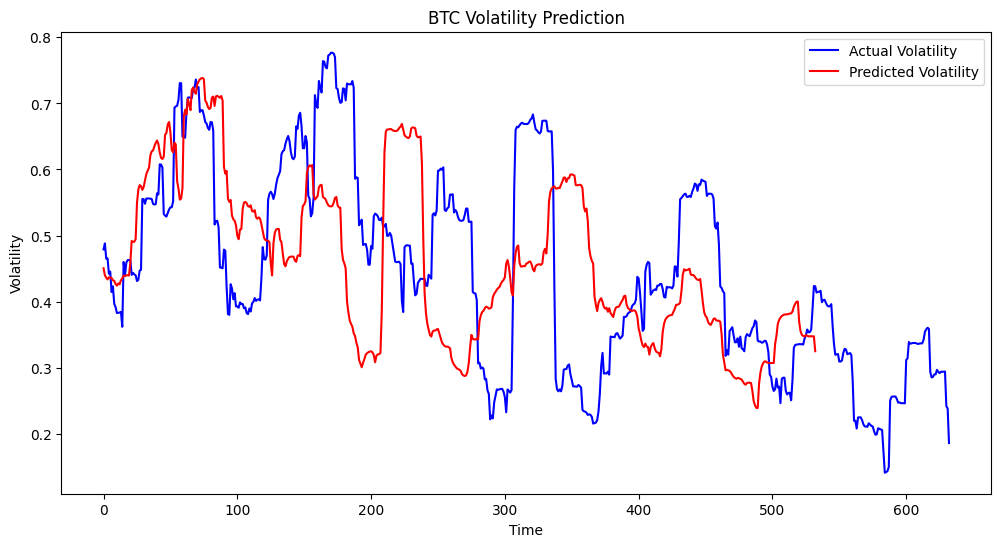

In [81]:
# Now we can evaluate the model on the test set
def evaluate_model(model: LSTM, data: pd.DataFrame):
    """Evaluate the model on the test set."""
    # First, transform the test data into the same format as the training data
    x, y = transform_data_to_training_timeseries(data)
    print(f"Test data shape: {x.shape}, Target shape: {y.shape}")
    prediction = model(x)
    metrics = compute_metrics(prediction, y)
    return metrics, prediction

# plot the predictions against the actual values
import matplotlib.pyplot as plt
def plot_predictions(predictions: jnp.ndarray, targets: jnp.ndarray):
    """Plot the predictions against the actual values."""
    plt.figure(figsize=(12, 6))
    plt.plot(targets, label='Actual Volatility', color='blue')
    plt.plot(predictions, label='Predicted Volatility', color='red')
    plt.title('BTC Volatility Prediction')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

# Evaluate the model on the test set
metrics, predictions = evaluate_model(lstm, test_data)
# get the last element of every series in predictions
  # Get the last element of each series

plot_predictions(predictions, test_data['Target'].to_numpy())